<a href="https://colab.research.google.com/github/nickocruzm/152.Phase3/blob/main/Research299_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports

In [ ]:
%%capture
# !pip install diffusers==0.32.2
# !pip install transformers==4.49
# !pip install --upgrade peft
#!pip install peft==0.17

!pip install open_clip_torch
!pip install accelerate
!pip install -q kaggle
!pip install torch-fidelity

from accelerate import Accelerator

from torch_fidelity import calculate_metrics
import math
import json
import random
import argparse
import itertools
import time
from diffusers.pipelines.stable_diffusion import safety_checker

from diffusers import (
    AutoencoderKL,
    DDPMScheduler,
    DDIMScheduler,
    DPMSolverMultistepScheduler,
    EulerDiscreteScheduler,
    EDMEulerScheduler,
    HeunDiscreteScheduler,
    LMSDiscreteScheduler,
    PNDMScheduler,
    StableDiffusionPipeline,
    UNet2DConditionModel,
    UniPCMultistepScheduler
)

from typing import Optional, List
from transformers import AutoTokenizer, CLIPTextModel, CLIPTokenizer
from PIL import Image
from pycocotools.coco import COCO

import pandas as pd

from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F

import os
import warnings

import torch
from torch.utils.data import DataLoader
from transformers import CLIPProcessor, CLIPModel
from torchvision import models, transforms
from PIL import Image
import torch.nn as nn


from google.colab import userdata, drive
warnings.filterwarnings('ignore')
drive.mount('/content/drive')

userdata.get("HF_TOKEN")
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

### CONSTANTS

In [ ]:
# Google Drive Directories
PROJECT_DIR = "/content/drive/MyDrive/Research299"
COCO_DIR = os.path.join(PROJECT_DIR, "COCO")
RAW_COCO_DIR = os.path.join(COCO_DIR, "raw")
GENERATED_COCO_DIR = os.path.join(COCO_DIR, "generated")
DATA_DIR = os.path.join(COCO_DIR, "data")

# captions file
COCO_CAPTIONS_PATH = os.path.join(COCO_DIR, "test_captions.csv")

# FID file's path
FID_PATH = os.path.join(DATA_DIR,'fid_scores.csv')
CLIP_PATH = os.path.join(DATA_DIR,'clip_scores.csv')

# MODEL ID's
SD_MODEL_ID = "runwayml/stable-diffusion-v1-5"
CLIP_MODEL_ID = "openai/clip-vit-base-patch32"

# Inception Model's Weights used to calculate FID
INCEPT_WEIGHTS = "IMAGENET1K_V1"

# Diffusion Model's Parameters
SD_PARAMS = {
    "num_inference_steps": 20
}

# pipeline's params
BATCH_SIZE = 5

# minimumum amount of images needed to be generated by scheduler to evaluate
COCO_MIN_IMAGE_COUNT = 4500

# Hugging face scheduler labels
SCHEDULER_LABELS = ["ddpm", "pndm", "ddim", "unipc", "lms", "heun", "eds", "edm"]

### Utilities

In [ ]:
from pathlib import Path
import pandas as pd

def diff_folders(dir1, dir2):
    """
        finds the difference between two directories.
        Used when ensuring all images are generated from real images.
    """
    files1 = {p.name for p in Path(dir1).iterdir() if p.is_file()}
    files2 = {p.name for p in Path(dir2).iterdir() if p.is_file()}

    only_in_dir1 = files1 - files2
    only_in_dir2 = files2 - files1

    return only_in_dir1, only_in_dir2

def count_images(img_dir:str, output:bool=False):
    """
        Count the number of images within a dir.
        Output is optional
    """
    imgs = {".jpg", ".jpeg", ".png"}
    count = sum(1 for p in Path(img_dir).iterdir() if p.suffix.lower() in imgs)
    s = os.path.basename(os.path.normpath(img_dir))

    if output: print(f"{s}:\t{count}")

    return count

def check_image_dimensions(directory_path, sched_lbl=None):
    """
    Checks all image files in a given directory for uniform dimensions.
    """
    if sched_lbl is None: sched_lbl = "unkown"

    if not os.path.isdir(directory_path):
        print(f"Directory '{directory_path}' does not exist.")
        return

    print(f"\nChecking image dimensions in '{sched_lbl}' \t full path: '{directory_path}')...")
    image_sizes = set()
    image_count = 0

    for f in os.listdir(directory_path):

        if not f.lower().endswith(('.png', '.jpg', '.jpeg')): continue

        image_count += 1
        img_path = os.path.join(directory_path, f)
        try:
            with Image.open(img_path) as img:
                image_sizes.add(img.size)
        except Exception as e:
            print(f"Error opening {img_path}: {e}")

    if image_count == 0:
        print(f"No images found in '{sched_lbl}'.")
    elif len(image_sizes) == 1:
        print(f"All {image_count} images in '{sched_lbl}' have uniform dimensions: {list(image_sizes)[0]}")
    else:
        print(f"Images in '{sched_lbl}' have varying dimensions: {image_sizes}")

def reset_generated_images():
    """
        Removes generated images from generated directory
        GENERATED_COCO_DIR: PROJECT_DIR/Research299/COCO/generated
        assumes the directory is already created.
    """
    img_types = ['.jpg', '.png', '.jpeg']
    for img in os.listdir(GENERATED_COCO_DIR):
        pth = os.path.join(GENERATED_COCO_DIR, img)
        os.unlink(pth)
    generated_images_count = sum(1 for p in Path(GENERATED_COCO_DIR).iterdir() if p.suffix.lower() in img_types)
    print(f'images found in generated directory: {generated_images_count}')

def setup_device():
    if torch.cuda.is_available():
        device_str = "cuda"
    elif torch.backends.mps.is_available():
        device_str = "mps"
    else:
        device_str = "cpu"
    print(f'device: {device_str}')
    return torch.device(device_str)

def remove_duplicates_by_scheduler(df, sched):
    grouped = df[df['scheduler'] == sched]
    print(f'old shape: {grouped.shape}')
    dups = grouped[grouped.duplicated(subset=['image_id', 'scheduler'], keep=False)]
    print(f'new shape: {dups.shape}')
    return dups

def get_real_tensors(incept_model):
    global DATA_DIR
    path1 = f'{DATA_DIR}/mu_real.pt'
    path2 = f'{DATA_DIR}/sigma_real.pt'

    if not (os.path.exists(path1) and os.path.exists(path2)):
        raw_image_paths = [
            os.path.join(RAW_COCO_DIR, f) for f in os.listdir(RAW_COCO_DIR) if os.path.isfile(os.path.join(RAW_COCO_DIR, f))
        ]
        mu_real, sigma_real = compute_stats(raw_image_paths, incept_model, device=device, batch_size=5)

        torch.save(mu_real, os.path.join(data_dir, "mu_real.pt"))
        torch.save(sigma_real, os.path.join(data_dir, "sigma_real.pt"))
        print(f"mu_real and sigma_real saved to {data_dir}")

    else:
        mu_real = torch.load(path1)
        sigma_real = torch.load(path2)

        print(f"mu_real and sigma_real loaded from {DATA_DIR}")

    return mu_real, sigma_real

def collect_captions(src_dir, captions_dir:str, captions:pd.DataFrame=None):
    """
        iterates through the RAW/real image file names strips the filenames
        to the image id and returns a dictionary of {image_id: caption}

        Grabs the first caption of the multiple captions in the list.
    """

    if captions is None: captions = pd.read_csv(captions_dir)

    gen_img_df = {}
    for img in os.listdir(src_dir):
        # convert image's file_name into an image_id.
        try:
            img_id = int(img.lstrip('0').removesuffix('.jpg'))
        except Exception as e:
            print("file is not image type")

        # locate image caption and store the first caption of the multiple given.
        prompt = captions[captions['image_id'] == img_id]['caption'].tolist()[0]

        if img_id in gen_img_df.keys():
            print("conflicting keys: ", img_id)
            continue
        else:
            gen_img_df[img_id] = prompt

    return gen_img_df

def compute_FID(real_dir, generated_dir, model, fid_scores, scheduler="ddpm",  mu_real=None, sigma_real=None):

    if mu_real is None and sigma_real is None:

        raw_image_paths = [
            os.path.join(real_dir, f) for f in os.listdir(real_dir) if os.path.isfile(os.path.join(real_dir, f))
        ]

        mu_real, sigma_real = compute_stats(raw_image_paths, model, device="cuda", batch_size=32)



    generated_image_paths = [
        os.path.join(generated_dir,f) for f in os.listdir(generated_dir)
        if os.path.isfile(os.path.join(generated_dir, f))
    ]

    fid_dict_key = f'{scheduler}_{len(generated_image_paths)}'

    if fid_dict_key not in fid_scores.keys():

        mu_gen, sigma_gen = compute_stats(generated_image_paths, model, device="cuda", batch_size=32)
        fid_score = frechet_distance(mu_gen, sigma_gen, mu_real, sigma_real)

        fid_scores[fid_dict_key] = fid_score
        print(f'FID score for {s}: {fid_score['mean']}')

def frechet_distance(mu1, sigma1, mu2, sigma2, eps: float = 1e-6) -> float:
    """
    FID = ||mu1-mu2||^2 + Tr(sigma1 + sigma2 - 2*sqrt(sigma1*sigma2))
    Uses stable symmetric form:
      sqrt(sigma1*sigma2) = sqrt( sqrt(sigma1) * sigma2 * sqrt(sigma1) )
    """
    mu1, mu2 = mu1.flatten(), mu2.flatten()
    diff = mu1 - mu2

    s1_sqrt = matrix_sqrt_psd(sigma1, eps=eps)
    middle = s1_sqrt @ sigma2 @ s1_sqrt
    middle_sqrt = matrix_sqrt_psd(middle, eps=eps)

    fid = diff.dot(diff) + torch.trace(sigma1) + torch.trace(sigma2) - 2.0 * torch.trace(middle_sqrt)
    return float(fid.item())

def compute_stats(image_paths, model, device="cuda", batch_size=BATCH_SIZE, num_workers=0):
    tfm = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])

    feats = []
    batch_number = 0
    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i+batch_size]
        imgs = []
        for p in batch_paths:
            img = Image.open(p).convert("RGB")
            imgs.append(tfm(img))

        x = torch.stack(imgs, dim=0).to(device)
        with torch.no_grad():
            f = model(x)  # (B, 2048)
        feats.append(f.detach().cpu())
        batch_number += 1

    feats = torch.cat(feats, dim=0)  # (N, 2048)
    mu = feats.mean(dim=0)
    sigma = cov_matrix(feats)
    return mu, sigma

def cov_matrix(X: torch.Tensor) -> torch.Tensor:
    """
    X: (N, D)
    returns: (D, D) covariance
    """
    X = X - X.mean(dim=0, keepdim=True)
    N = X.shape[0]
    return (X.T @ X) / (N - 1)

def matrix_sqrt_psd(A: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
    """
    Symmetric PSD matrix square root using eigendecomposition.
    """
    A = (A + A.T) * 0.5  # enforce symmetry
    evals, evecs = torch.linalg.eigh(A)
    evals = torch.clamp(evals, min=eps)
    sqrt_evals = torch.sqrt(evals)
    return (evecs * sqrt_evals.unsqueeze(0)) @ evecs.T

def compute_CLIP_scores(dir, schedule, image_ids, clip_captions, device):
    G = []
    for id in image_ids:
        path = f'{dir}/{id}.png'
        img = Image.open(path).convert("RGB")
        G.append(path)

    inputs = clip_processor(
        text=clip_captions,
        images=G,
        return_tensors="pt",
        padding=True
    ).to(device)

    outputs = clip_model(**inputs)
    scores = torch.diag(outputs.logits_per_image).detach().cpu()
    scores = scores.tolist()

    return pd.DataFrame({
        "image_id":image_ids,
        "scheduler":[schedule] * len(image_ids),
        "clip_score": scores
    })

def get_schedulers_status():
    """
        Determine which schedulers no longer need images generated for.
        Gets the count of images generated in each directory
    """
    global SCHEDULER_LABELS
    COCO_MIN_IMAGE_COUNT = 4500

    if SCHEDULER_LABELS is None:
        SCHEDULER_LABELS = ["ddpm", "pndm", "ddim", "unipc", "lms", "heun", "eds", "edm"]

    images_generated = {s:0 for s in SCHEDULER_LABELS}
    generated_complete = {s:False for s in SCHEDULER_LABELS}

    for s in SCHEDULER_LABELS:
        dir = GENERATED_COCO_DIR + f'/{s}'

        os.makedirs(dir, exist_ok=True)

        c = count_images(dir, output=True)

        if c > COCO_MIN_IMAGE_COUNT:
            generated_complete[s] = True
            images_generated[s] = c

    return generated_complete, images_generated

## COCODataset Class

In [ ]:
from torch.utils.data import Dataset
import torch

class COCODataset(Dataset):
    def __init__(self, image_dir, image_ids, captions):
        self.image_dir = image_dir
        self.image_ids = image_ids
        self.captions = captions


    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]


        caption = self.captions[img_id]

        return {
            "image_id": img_id,
            "caption": caption
        }


## Initialization


In [ ]:
device = setup_device()

pipe = StableDiffusionPipeline.from_pretrained(
    SD_MODEL_ID,
    torch_dtype=torch.float16,
    num_images_per_prompt=1,
    num_inference_steps = SD_PARAMS['num_inference_steps']
).to(device)

clip_model = CLIPModel.from_pretrained(CLIP_MODEL_ID).to(device)
clip_processor = CLIPProcessor.from_pretrained(CLIP_MODEL_ID)


# dictionary with {image_id: caption}
captions_dict = collect_captions(RAW_COCO_DIR, COCO_CAPTIONS_PATH)
# list of image_ids from captions
image_ids = list(int(k) for k in captions_dict.keys())
image_ids = sorted(image_ids)

raw_dataset = COCODataset(
    RAW_COCO_DIR,
    image_ids,
    captions_dict
)

device: cuda


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

file is not image type
conflicting keys:  573258


### Scheduler Dictionary
all schedulers are imported from diffusers library

count the number of images generated by each scheduler, sort keys by image count in ascending order to start generation of images using the scheduler with the least amount of images generated.


In [ ]:
from pathlib import Path
import os

huggingFace_schedulers = {
    "ddpm":DDPMScheduler,
    "pndm":PNDMScheduler,
    "ddim":DDIMScheduler,
    "unipc":UniPCMultistepScheduler,
    "lms":LMSDiscreteScheduler,
    "heun":HeunDiscreteScheduler,
    "eds":EulerDiscreteScheduler,
    "edm":EDMEulerScheduler
}

generation_completed, images_generated = get_schedulers_status()
# sort schedulers in ascending order by number of images already generated
sorted_scheduler_keys = [k for k,_ in sorted(images_generated.items(), key=lambda x: x[1])]
# start with scheduler that has the smallest count of images generated
schedulers = {k: huggingFace_schedulers[k] for k in sorted_scheduler_keys}

ddpm:	5000
pndm:	5000
ddim:	5000
unipc:	5000
lms:	5000
heun:	4998
eds:	4980
edm:	5000


Set up the `clip_scores.csv` file.

In [ ]:
# Check if the CSV file exists and is not empty
if os.path.exists(CLIP_PATH) and os.path.getsize(CLIP_PATH) > 0:
    clip_df = pd.read_csv(CLIP_PATH)
else:
    # If the file doesn't exist or is empty, create an empty DataFrame with headers
    clip_df = pd.DataFrame(columns=['image_id', 'scheduler', 'clip_score'])
    # Save the empty DataFrame with headers to the file
    clip_df.to_csv(CLIP_PATH, index=False) # Save with header to prevent future EmptyDataError

print(f'original CLIP scores: {clip_df.shape}')

original CLIP scores: (38210, 3)


#### Rough patch removing duplicates

In [ ]:
clip_df = pd.read_csv(CLIP_PATH)
unique_df = clip_df.drop_duplicates(subset=["image_id", "scheduler"], keep="first")
labels = [x for x in schedulers.keys()]
count = 0
for s in labels:
    instances = unique_df.loc[unique_df['scheduler'] == s].shape[0]
    print(f'{s}: {unique_df.loc[unique_df['scheduler'] == s].shape}')
    count += instances
print(f'total: {count}')

unique_df.to_csv(CLIP_PATH, index=False)

# No shape should have greater than 5000 rows
print(f'{unique_df.shape}')


eds: (3500, 3)
heun: (3597, 3)
ddpm: (4496, 3)
pndm: (4017, 3)
ddim: (3997, 3)
unipc: (5000, 3)
lms: (4792, 3)
edm: (5000, 3)
total: 34399
duplicates removed: (34399, 3)


## Main Inference Loop


- Images Generated are saved to drive
- Clip scores computes are saved to .csv file.

- Inference loop only generates new image and computes new clip scores.
    - If the clip scores or images generated are found in csv then they are not added to the batch.


- will switch schedulers every N batches.

- FID scores are computed after the inference loop finishes.


In [ ]:
clip_df = pd.read_csv(CLIP_PATH)
print(f'CLIP SCORES: {clip_df.shape}')
clip_df.set_index(['image_id','scheduler'], inplace=True)

for scheduler_lbl, Sched in schedulers.items():
    print(f'SCHEDULER: {scheduler_lbl}')
    # switch scheduler
    pipe.scheduler = Sched.from_config(pipe.scheduler.config)

    # directory with real images
    real_dir = RAW_COCO_DIR

    # directory with generated images
    generated_dir = os.path.join(GENERATED_COCO_DIR, scheduler_lbl)

    # directory with scores saved csv files
    data_dir = os.path.join(COCO_DIR,'data')

    # creates the directories if it doesn't exist, else does nothing
    os.makedirs(real_dir, exist_ok=True)
    os.makedirs(generated_dir, exist_ok=True)
    os.makedirs(data_dir, exist_ok=True)

    # set loader
    loader = DataLoader(
        raw_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False
    )

    # reset after switching schedulers
    batch_idx = 1

    # will only count the newly generated images
    totals ={
        'images_generated':0,
        'clips_computed': 0,
    }

    with torch.no_grad():
        for batch in loader:
            # get captions and image_ids from batch
            captions, img_ids = batch["caption"], batch["image_id"].tolist()

            # for each batch reset generative caps and generative ids.
            gen_caps, gen_ids = [],[]
            clip_caps, clip_ids = [],[]

            # iterate through batch and collect unused captions and ids
            for cap, img_id in zip(captions, img_ids):

                outpath = f'{generated_dir}/{img_id}.png'

                # if the file doesn't exist then we haven't generated it yet
                if not os.path.exists(outpath):
                    gen_caps.append(cap)
                    gen_ids.append(img_id)

                # if the id and scheduler is not in the index then we have not yet generated a clip score
                if (img_id, scheduler_lbl) not in clip_df.index:
                    print(f'CLIP: {img_id}, {scheduler_lbl}')
                    clip_ids.append(img_id)
                    clip_caps.append(cap)



            if gen_ids:
                generated_images = pipe(gen_caps, num_inference_steps=20).images
                images_generated[scheduler_lbl] += len(generated_images)
                totals['images_generated'] += len(generated_images)
                print(f'\tGENERATED {len(generated_images)} IMAGES')

                # Save generated images
                for img, gid in zip(generated_images, gen_ids):
                    out_path = f'{generated_dir}/{gid}.png'
                    img.save(out_path)

            if clip_ids:

                totals['clips_computed'] += len(clip_ids)
                scores = compute_CLIP_scores(generated_dir, scheduler_lbl, clip_ids, clip_caps, device)
                print(f'\tCOMPUTED {len(clip_ids)} CLIP SCORES')
                indexed_scores = scores.set_index(['image_id','scheduler'], inplace=False)
                clip_df = pd.concat([clip_df,indexed_scores])

                scores.to_csv(
                    CLIP_PATH,
                    mode='a',
                    index=False,
                    header= not os.path.exists(CLIP_PATH)
                )



            if batch_idx % 10 == 0:
                print(f'scheduler name: {scheduler_lbl}, batch_idx: {batch_idx}')

            if batch_idx % 100 == 0:
                break

            if clip_ids or gen_ids:
                batch_idx += 1


CLIP SCORES: (34429, 3)
SCHEDULER: eds
CLIP: 289594, eds
CLIP: 289659, eds
CLIP: 289702, eds
CLIP: 289741, eds
CLIP: 289938, eds
	COMPUTED 5 CLIP SCORES
CLIP: 289960, eds
CLIP: 289992, eds
CLIP: 290081, eds
CLIP: 290163, eds
CLIP: 290179, eds
	COMPUTED 5 CLIP SCORES
CLIP: 290248, eds
CLIP: 290293, eds
CLIP: 290592, eds
CLIP: 290619, eds
CLIP: 290768, eds
	COMPUTED 5 CLIP SCORES
CLIP: 290771, eds
CLIP: 290833, eds
CLIP: 290843, eds
CLIP: 291490, eds
CLIP: 291551, eds
	COMPUTED 5 CLIP SCORES
CLIP: 291619, eds
CLIP: 291634, eds
CLIP: 291664, eds
CLIP: 291791, eds
CLIP: 291861, eds
	COMPUTED 5 CLIP SCORES
CLIP: 292005, eds
CLIP: 292024, eds
CLIP: 292060, eds
CLIP: 292082, eds
CLIP: 292155, eds
	COMPUTED 5 CLIP SCORES
CLIP: 292225, eds
CLIP: 292236, eds
CLIP: 292330, eds
CLIP: 292415, eds
CLIP: 292446, eds
	COMPUTED 5 CLIP SCORES
CLIP: 292456, eds
CLIP: 292488, eds
CLIP: 292908, eds
CLIP: 292997, eds
CLIP: 293044, eds
	COMPUTED 5 CLIP SCORES
CLIP: 293071, eds
CLIP: 293200, eds
CLIP: 293245,

  0%|          | 0/20 [00:00<?, ?it/s]

	GENERATED 1 IMAGES
	COMPUTED 5 CLIP SCORES
CLIP: 304365, heun
CLIP: 304404, heun
CLIP: 304545, heun
CLIP: 304560, heun
	COMPUTED 4 CLIP SCORES
CLIP: 304812, heun
CLIP: 304817, heun
CLIP: 304984, heun
CLIP: 305309, heun
CLIP: 305317, heun
	COMPUTED 5 CLIP SCORES
CLIP: 305343, heun
CLIP: 305609, heun
CLIP: 305695, heun
CLIP: 306136, heun
CLIP: 306139, heun
	COMPUTED 5 CLIP SCORES
scheduler name: heun, batch_idx: 30
CLIP: 306437, heun
CLIP: 306582, heun
CLIP: 306700, heun
CLIP: 306733, heun
CLIP: 306893, heun
	COMPUTED 5 CLIP SCORES
CLIP: 307145, heun
CLIP: 307172, heun
CLIP: 307658, heun
	COMPUTED 3 CLIP SCORES
CLIP: 308165, heun
CLIP: 308193, heun
CLIP: 308328, heun
CLIP: 308391, heun
CLIP: 308394, heun
	COMPUTED 5 CLIP SCORES
CLIP: 308466, heun
CLIP: 308476, heun
CLIP: 308531, heun
CLIP: 308545, heun
	COMPUTED 4 CLIP SCORES
CLIP: 308587, heun
CLIP: 308631, heun
CLIP: 308753, heun
CLIP: 308799, heun
	COMPUTED 4 CLIP SCORES
CLIP: 309391, heun
CLIP: 309452, heun
CLIP: 309467, heun
CLIP: 

  0%|          | 0/20 [00:00<?, ?it/s]

	GENERATED 1 IMAGES
	COMPUTED 4 CLIP SCORES
CLIP: 318080, heun
CLIP: 318114, heun
CLIP: 318138, heun
CLIP: 318238, heun
	COMPUTED 4 CLIP SCORES
scheduler name: heun, batch_idx: 50
CLIP: 318455, heun
CLIP: 318908, heun
CLIP: 319184, heun
CLIP: 319369, heun
	COMPUTED 4 CLIP SCORES
CLIP: 319534, heun
CLIP: 319607, heun
CLIP: 319617, heun
CLIP: 319696, heun
CLIP: 319721, heun
	COMPUTED 5 CLIP SCORES
CLIP: 319935, heun
CLIP: 320232, heun
CLIP: 320425, heun
CLIP: 320490, heun
CLIP: 320554, heun
	COMPUTED 5 CLIP SCORES
CLIP: 320632, heun
CLIP: 320664, heun
CLIP: 320696, heun
	COMPUTED 3 CLIP SCORES
CLIP: 320743, heun
CLIP: 321118, heun
CLIP: 321214, heun
CLIP: 321333, heun
CLIP: 321557, heun
	COMPUTED 5 CLIP SCORES
CLIP: 321790, heun
CLIP: 321887, heun
CLIP: 322163, heun
CLIP: 322211, heun
CLIP: 322352, heun
	COMPUTED 5 CLIP SCORES
CLIP: 322429, heun
CLIP: 322574, heun
CLIP: 322610, heun
CLIP: 322724, heun
CLIP: 322829, heun
	COMPUTED 5 CLIP SCORES
CLIP: 322844, heun
CLIP: 322864, heun
CLIP: 

- Number of total generated images by scheduler.
- Images Generated have uniform sizing of (512x512)

In [ ]:

images_generated = {s:0 for s in SCHEDULER_LABELS}

for s in SCHEDULER_LABELS:
    dir = GENERATED_COCO_DIR + f'/{s}'

    os.makedirs(dir, exist_ok=True)

    c = count_images(dir, output=False)
    print(f'{s}: \t {c}')

    if c > COCO_MIN_IMAGE_COUNT:
        images_generated[s] = c


ddpm: 	 5000
pndm: 	 5000
ddim: 	 5000
unipc: 	 5000
lms: 	 5000
heun: 	 4998
eds: 	 4980
edm: 	 5000


### FID scores

In [ ]:
from torchvision import models
import torch.nn as nn

incept_model = models.inception_v3(weights=INCEPT_WEIGHTS, transform_input=False)
# remove classifier
incept_model.fc = nn.Identity()
# disable aux branch
incept_model.aux_logits = False
incept_model.eval().cuda()

generated_image_paths={}
labels = [x for x in schedulers.keys()]


if os.path.exists(FID_PATH) and os.path.getsize(FID_PATH) > 0:
    fid_scores_df = pd.read_csv(FID_PATH)
else:
    # If the file doesn't exist or is empty, create an empty DataFrame with headers
    # Save the empty DataFrame with headers to the file
    pd.DataFrame(columns=['scheduler', 'fid_score']).to_csv(FID_PATH, index=False)


    fid_scores_df = pd.read_csv(FID_PATH)

mu_real, sigma_real = get_real_tensors(incept_model)


# incept_model = models.inception_v3(pretrained=True, aux_logits=True)
# incept_model.fc = nn.Identity()
# incept_model.aux_logits = False
# incept_model.eval().to(torch.device("cuda"))

fid_scores = {}
for s in labels:
    if s in fid_scores_df['scheduler'].values:
        print(f'already computed {s}')
        continue

    s_dir = f'{GENERATED_COCO_DIR}/{s}'
    paths = [
        os.path.join(s_dir,f) for f in os.listdir(s_dir)
        if os.path.isfile(os.path.join(s_dir, f))
    ]

    mu_gen, sigma_gen = compute_stats(paths, incept_model, device="cuda", batch_size=32)
    fid_scores[s] = frechet_distance(mu_gen, sigma_gen, mu_real, sigma_real)
    print(f'FID score for {s}: {fid_scores[s]}')

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


100%|██████████| 104M/104M [00:00<00:00, 215MB/s] 


Streaming output truncated to the last 5000 lines.
	 p: /content/drive/MyDrive/Research299/COCO/generated/edm/330818.png
	 p: /content/drive/MyDrive/Research299/COCO/generated/edm/331075.png
	 p: /content/drive/MyDrive/Research299/COCO/generated/edm/334006.png
	 p: /content/drive/MyDrive/Research299/COCO/generated/edm/334309.png
	 p: /content/drive/MyDrive/Research299/COCO/generated/edm/334371.png
	 p: /content/drive/MyDrive/Research299/COCO/generated/edm/334399.png
	 p: /content/drive/MyDrive/Research299/COCO/generated/edm/334417.png
i: 160, batch: 5
	 p: /content/drive/MyDrive/Research299/COCO/generated/edm/334483.png
	 p: /content/drive/MyDrive/Research299/COCO/generated/edm/334521.png
	 p: /content/drive/MyDrive/Research299/COCO/generated/edm/334530.png
	 p: /content/drive/MyDrive/Research299/COCO/generated/edm/334555.png
	 p: /content/drive/MyDrive/Research299/COCO/generated/edm/334719.png
	 p: /content/drive/MyDrive/Research299/COCO/generated/edm/334767.png
	 p: /content/drive/My

In [ ]:
fid_scores

{'eds': 26.784271240234375,
 'heun': 26.48236083984375,
 'ddpm': 29.48480224609375,
 'pndm': 25.57440185546875,
 'ddim': 25.384002685546875,
 'unipc': 27.526885986328125,
 'lms': 26.584686279296875,
 'edm': 465.3114013671875}

### CLIP data

In [ ]:
clip_df = pd.read_csv(CLIP_PATH)
print(clip_df.shape)
unique_df = clip_df.drop_duplicates(subset=["image_id", "scheduler"], keep="first")
unique_df.shape

(36954, 3)


(36924, 3)

In [ ]:
labels = [x for x in schedulers.keys()]
count = 0
for s in labels:
    instances = unique_df.loc[unique_df['scheduler'] == s].shape[0]
    print(f'{s}: {unique_df.loc[unique_df['scheduler'] == s].shape}')
    count += instances
print(f'total: {count}')

eds: (3999, 3)
heun: (4055, 3)
ddpm: (4953, 3)
pndm: (4474, 3)
ddim: (4454, 3)
unipc: (5000, 3)
lms: (4989, 3)
edm: (5000, 3)
total: 36924


In [ ]:
for s in labels:
    print(s)
    print(unique_df.loc[unique_df['scheduler'] == s].describe())

eds
            image_id   clip_score
count    3999.000000  3999.000000
mean   259527.938235    31.254709
std    173864.742494     2.903805
min       139.000000    18.849606
25%    119299.000000    29.369969
50%    229747.000000    31.177143
75%    347413.000000    33.139845
max    581781.000000    42.946587
heun
            image_id   clip_score
count    4055.000000  4055.000000
mean   261207.523798    31.296409
std    173260.675079     2.872615
min       139.000000    19.663206
25%    120942.000000    29.366270
50%    232244.000000    31.240030
75%    400187.500000    33.180149
max    581781.000000    41.941254
ddpm
            image_id   clip_score
count    4953.000000  4953.000000
mean   288932.948718    31.277321
std    168279.039432     2.924710
min       139.000000    18.752663
25%    146489.000000    29.373322
50%    287545.000000    31.259928
75%    437239.000000    33.150562
max    581781.000000    43.509571
pndm
            image_id   clip_score
count    4474.000000  4474.00

## Results

### Histograms of clip Scores


#### by scheduler

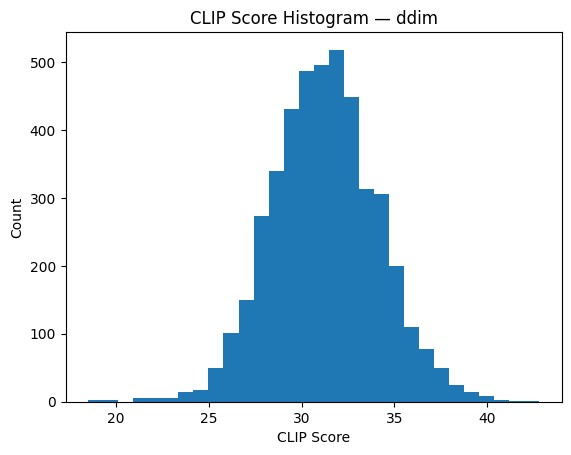

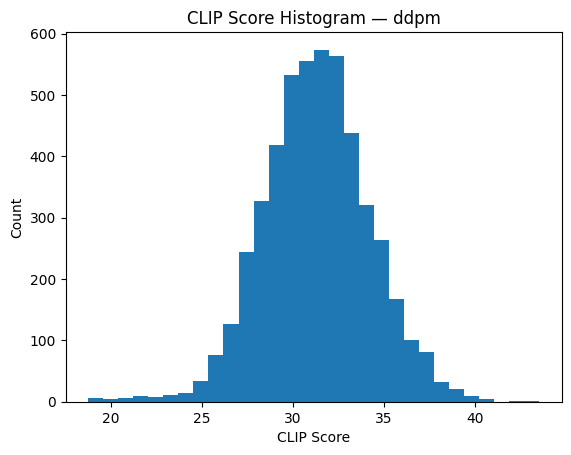

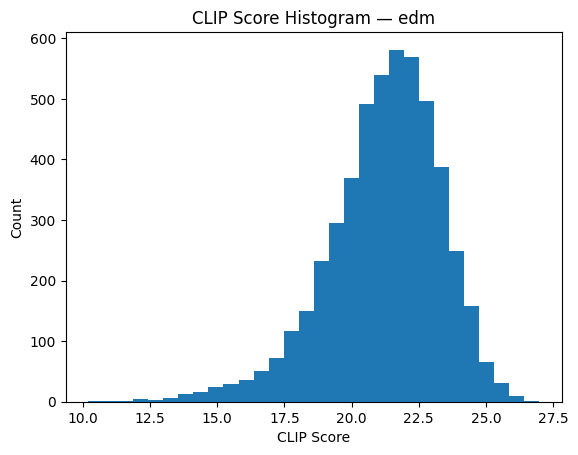

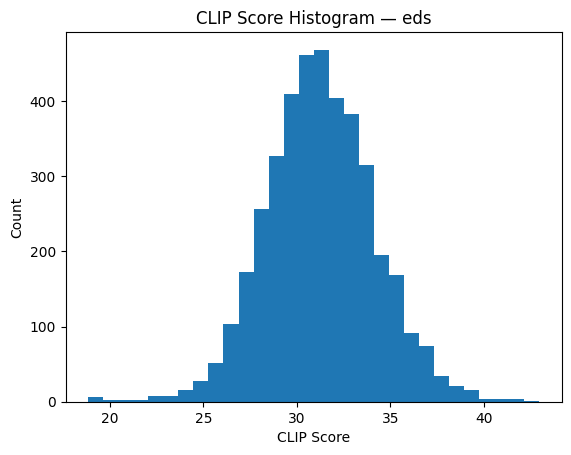

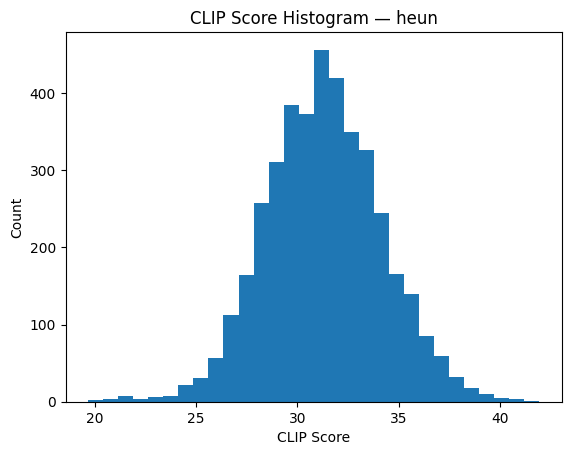

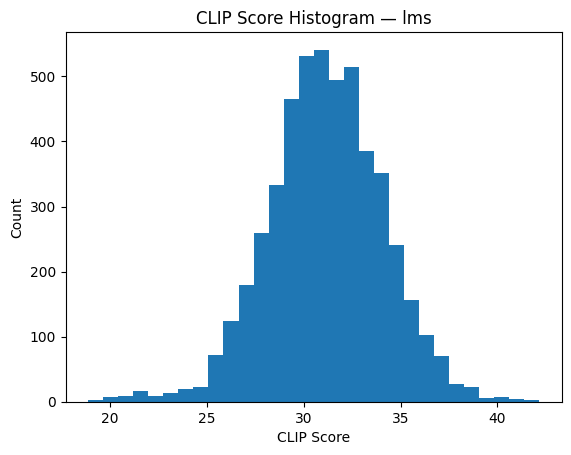

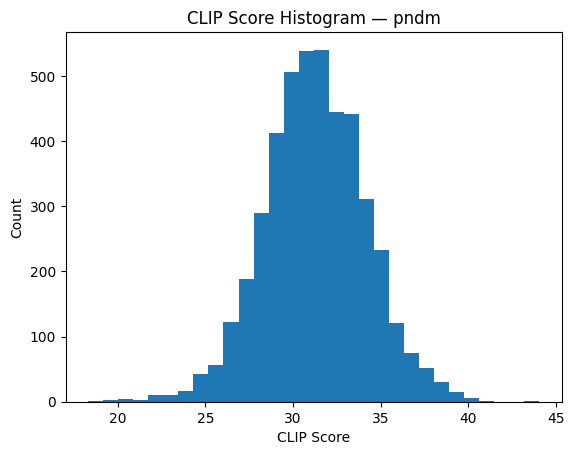

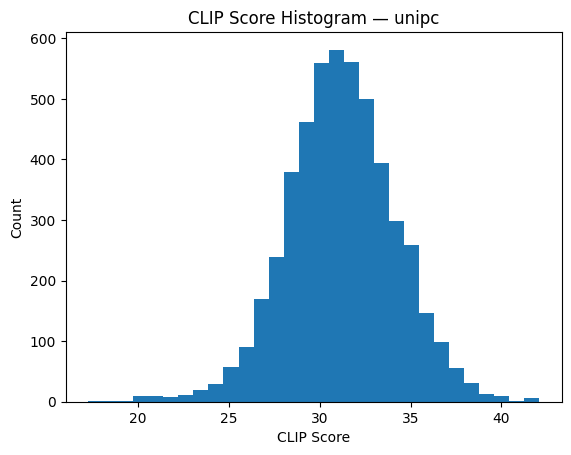

In [ ]:
import matplotlib.pyplot as plt
clip_df = pd.read_csv(CLIP_PATH)
for scheduler, g in clip_df.groupby('scheduler'):
    plt.figure()
    plt.hist(g['clip_score'], bins=30)
    plt.title(f'CLIP Score Histogram — {scheduler}')
    plt.xlabel('CLIP Score')
    plt.ylabel('Count')
    plt.show()

#### Overlays

##### All schedulers

##### EDM underperforms

    - Early steps remove structure-level noise.
    - Later steps focus on fine details.
    - Takes large denoising steps when noise is high.
    - Uses Euler/Heun solvers like an ODE.


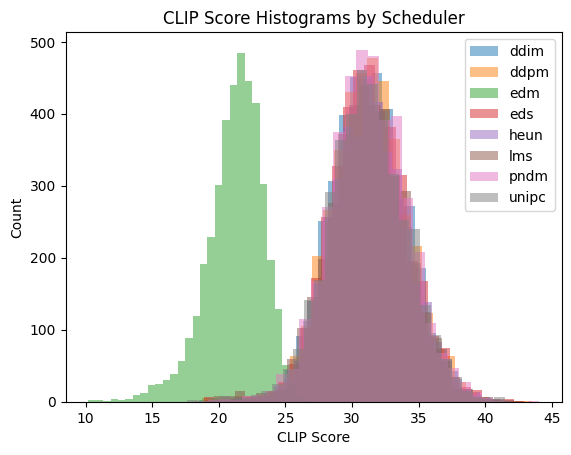

In [ ]:
df = clip_df.copy()
N = min(df['scheduler'].value_counts())
plt.figure()
for scheduler, g in df.groupby('scheduler'):
    g_equalized = g.sample(n=N, random_state=42)
    plt.hist(g_equalized['clip_score'], bins=30, alpha=0.5, label=scheduler)

plt.legend()
plt.xlabel('CLIP Score')
plt.ylabel('Count')
plt.title('CLIP Score Histograms by Scheduler')
plt.show()

##### ddim and ddpm

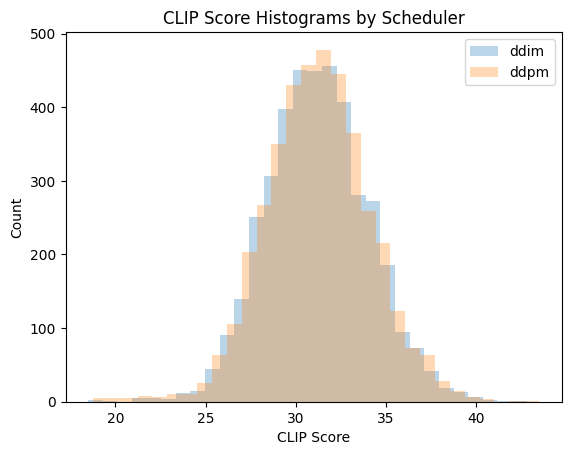

In [ ]:
N = min(df['scheduler'].value_counts())
selected_schedulers = ['ddpm', 'ddim']
plt.figure()
for scheduler, g in df.groupby('scheduler'):
    if scheduler not in selected_schedulers: continue
    g_equalized = g.sample(n=N, random_state=42)
    plt.hist(g_equalized['clip_score'], bins=30, alpha=0.3, label=scheduler)

plt.legend()
plt.xlabel('CLIP Score')
plt.ylabel('Count')
plt.title('CLIP Score Histograms by Scheduler')
plt.show()

##### Density

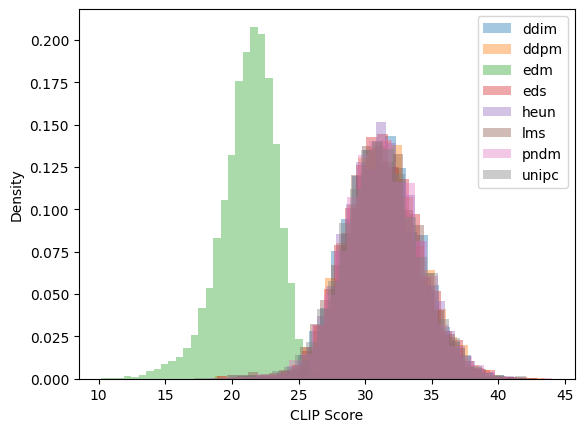

In [ ]:
plt.figure()
for scheduler, g in df.groupby("scheduler"):
    plt.hist(
        g["clip_score"],
        bins=30,
        density=True,
        alpha=0.4,
        label=scheduler
    )

plt.xlabel("CLIP Score")
plt.ylabel("Density")
plt.legend()
plt.show()

##### KDE

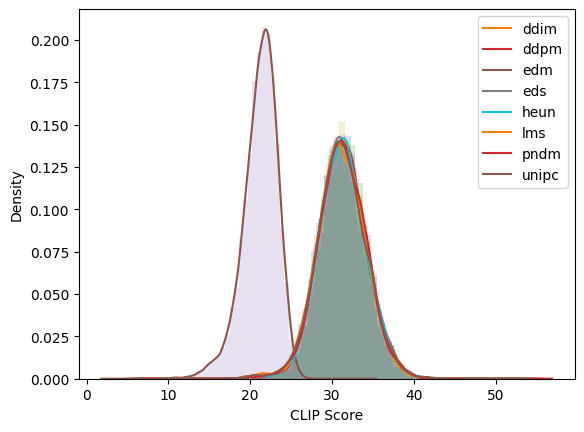

In [ ]:
import numpy as np

plt.figure()
for scheduler, g in df.groupby("scheduler"):
    plt.hist(g["clip_score"], bins=30, density=True, alpha=0.2)
    g["clip_score"].plot(kind="kde", label=scheduler)

plt.xlabel("CLIP Score")
plt.ylabel("Density")
plt.legend()
plt.show()